In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import tensorflow as tf
tf.reset_default_graph()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import imutils,random

from tqdm import tqdm
from sklearn.utils import shuffle

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#label_file_path = '.\Final Peta Dataset\\AllLabels3.txt'
label_file_path = '.\PETA2\AllLabels3.txt'
#images_path_dir = '.\Final Peta Dataset\\Images'
images_path_dir = '.\PETA2\\Images'

def import_labels(path):
    f = open(path,'r')   #Read every line from final label file
    lines = f.readlines()
    f.close()
    
    i = 0
    while i < len(lines):
        lines[i] = lines[i].rstrip('\n')    #For removing newline at the end of every line
        i += 1

   
    labels = []
    for i in lines:
        h = i.split(' ')         
        labels.append(h)     #Final label list with every label as a column
    
    return labels



def import_images(path):
    images = []
    for i in tqdm(os.listdir(path)):
        image_path = os.path.join(path,i)
        image_data = cv2.imread(image_path)
        image_data_flat = image_data.shape[0]*image_data.shape[1]
        if image_data_flat > 120*60:
            image_data = cv2.resize(image_data,(60,120),cv2.INTER_AREA)
        else:
            image_data = cv2.resize(image_data,(60,120),cv2.INTER_LINEAR)
            
        images.append(image_data)
    
    return images


def merge_data(labels,images):
    data = []
    i = 0
    while i < len(images):
        data.append([images[i],labels[i]])
        i += 1
    data = shuffle(data)
    np.save('PedData4.3.npy',data)
    return data

def aug_data(trainX,trainY):      #Augments flipped images and corresponding labels to train dataset and returns a new data which
    augdata = []                  #has to split into X_train and Y_train
    for i,j in enumerate(trainX):
        augdata.append([trainX[i],trainY[i]])
    
    #Adds Horizontally flipped images
    for i,j in enumerate(trainX):
        horflipped = np.fliplr(trainX[i])
        augdata.append([horflipped,trainY[i]])
    #Adds rotated images- rotation angle 10-15degree
    for i,j in enumerate(trainX):
      rotated = imutils.rotate(trainX[i],random.randint(10,16))
      augdata.append([rotated,trainY[i]])
    '''   
    #Adds cropped images of top area for the face
    for i in range(len(trainX)):
        lx,ly,lz = trainX[i].shape
        cropped_face = trainX[i][0:lx//5,:]
        cropped_face = cv2.resize(cropped_face,(60,120),cv2.INTER_LANCZOS4)  #For sharp scaling. Cubic and linear is also good
        augdata.append([cropped_face,trainY[i]])
    '''
    
    #augdata = shuffle(augdata)  #Shuffling full pedestrian augmented dataset for learning so many attributes creates problem in learning 
    return augdata



#labels = import_labels(label_file_path)
#images = import_images(images_path_dir)
#data = merge_data(labels,images)

data = np.load('/content/gdrive/My Drive/PedDataset/PedData4.3.npy')f

X = [i[0] for i in data]
Y = [i[1] for i in data]

X = np.reshape(X,(len(X),120,60,3))
X = X.astype(np.float32)                  


a = MultiLabelBinarizer()
Y = np.array(Y)
Y = a.fit_transform(Y)
Y = Y[:,1:]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.20,random_state=0)

augtraindata = aug_data(X_train,Y_train)

X_train_aug = [i[0] for i in augtraindata]
Y_train_aug = [i[1] for i in augtraindata]

X_train_aug = np.array(X_train_aug)
Y_train_aug = np.array(Y_train_aug)

num_cols = 120*60*3
num_clasess = 47
learning_rate = .0005
training_epochs = 20
batch_size = 100

x = tf.placeholder(tf.float32,[None,120,60,3])
y = tf.placeholder(tf.float32,[None,num_clasess])
drop1 = tf.placeholder(tf.float32)
drop2 = tf.placeholder(tf.float32)

Weights = {
    'W_Conv1':tf.Variable(tf.random_normal([3,3,3,32])), #60x30
    'W_Conv2':tf.Variable(tf.random_normal([3,3,32,64])),#30x15 
    'W_Conv3':tf.Variable(tf.random_normal([3,3,64,128])),#30x15   #64,128,256 these high number filters doesn't work
    'W_fc1':tf.Variable(tf.random_normal([30*15*128,2048])),
    'W_fc2':tf.Variable(tf.random_normal([2048,1024])),
    'out':tf.Variable(tf.random_normal([1024,47]))
}

Biases = {
    'B_Conv1':tf.Variable(tf.random_normal([32])),
    'B_Conv2':tf.Variable(tf.random_normal([64])),
    'B_Conv3':tf.Variable(tf.random_normal([128])),
    'B_fc1':tf.Variable(tf.random_normal([2048])),
    'B_fc2':tf.Variable(tf.random_normal([1024])),
    'out':tf.Variable(tf.random_normal([47]))
}     

def PedCnn(x,Weights,Biases):
    x = tf.reshape(x,[-1,120,60,3])
    
    conv1 = tf.nn.conv2d(x,Weights['W_Conv1'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv1']
    conv1 = tf.nn.relu(conv1)
    mean1,var1 = tf.nn.moments(conv1,axes=[0])
    conv1 = tf.nn.batch_normalization(conv1,mean1,var1,offset=0,scale=1,variance_epsilon=1e-8)
    conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    
    conv2 = tf.nn.conv2d(conv1,Weights['W_Conv2'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv2']
    conv2 = tf.nn.relu(conv2)
    mean2,var2 = tf.nn.moments(conv2,axes=[0])
    conv2 = tf.nn.batch_normalization(conv2,mean2,var2,offset=0,scale=1,variance_epsilon=1e-8)
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    
    conv3 = tf.nn.conv2d(conv2,Weights['W_Conv3'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv3']
    conv3 = tf.nn.relu(conv3)
    mean3,var3 = tf.nn.moments(conv3,axes=[0])
    conv3 = tf.nn.batch_normalization(conv3,mean3,var3,offset=0,scale=1,variance_epsilon=1e-8)
    conv3 = tf.nn.max_pool(conv3,ksize=[1,2,2,1],strides=[1,1,1,1],padding='SAME')
    
  
    fc1 = tf.reshape(conv3,[-1,30*15*128])
    
    fc1 = tf.matmul(fc1,Weights['W_fc1']) + Biases['B_fc1']
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.layers.dropout(fc1,drop1)
    
    fc2 = tf.matmul(fc1,Weights['W_fc2']) + Biases['B_fc2']
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.layers.dropout(fc2,drop2)
    
    out = tf.matmul(fc2,Weights['out']) + Biases['out']
    return out

ypred = PedCnn(x,Weights,Biases)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=ypred,labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)


correct_predictions = tf.equal(tf.round(tf.nn.sigmoid(ypred)),tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver(save_relative_paths=True)

sess = tf.Session()
sess.run(init)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.


In [0]:
#For restoring trained model
saver2 = tf.train.import_meta_graph('/content/gdrive/My Drive/FinalPedModel/Arif.meta')
saver2.restore(sess,tf.train.latest_checkpoint('/content/gdrive/My Drive/FinalPedModel/'))

In [0]:
test_accuracy_history = []
train_accuracy_history = []
cost_history = []

In [0]:

#for training on training augmented data and find accuracy on test
batch_size = 100

totalbatchtrain = int(len(X_train)/batch_size)
totalbatchtest = int(len(X_test)/batch_size)
for i in range(30):
    #Finds cost and train per epoch
    sum_cost = 0
    m = 0
    for j in range(totalbatchtrain):
        X_batch_train,Y_batch_train = X_train_aug[m:m+batch_size],Y_train_aug[m:m+batch_size]
        _,cost = sess.run([train,loss],{x:X_batch_train,y:Y_batch_train,drop1:0.40,drop2:0.30})
        m += batch_size
        sum_cost += cost
        
    avg_cost = sum_cost/totalbatchtrain   
    cost_history.append(avg_cost)
    
    #Finds test accuracy per epoch
    m = 0
    sum_acc = 0
    for j in range(totalbatchtest):
      X_batch_test,Y_batch_test = X_test[m:m+batch_size],Y_test[m:m+batch_size]
      m+=batch_size
      acc = sess.run(accuracy,{x:X_batch_test,y:Y_batch_test,drop1:0.00,drop2:0.00})
      sum_acc += acc

    avg_acc1 = sum_acc/totalbatchtest
    test_accuracy_history.append(avg_acc1)
    
    print(f'Epoch {i},Cost {avg_cost}')
    
    #Finds train accuracy per epoch
    m = 0
    sum_acc = 0
    for j in range(totalbatchtrain):
      X_batch_train,Y_batch_train = X_train_aug[m:m+batch_size],Y_train_aug[m:m+batch_size]
      m+=batch_size
      acc = sess.run(accuracy,{x:X_batch_train,y:Y_batch_train,drop1:0.00,drop2:0.00})
      sum_acc += acc

    avg_acc2 = sum_acc/totalbatchtrain
    train_accuracy_history.append(avg_acc2)
    
    print(f'Test accuracy - {avg_acc1} Train Accuracy = {avg_acc2}')
    

Epoch 0,Cost 8276.758535284745
Test accuracy - 0.8177099667097393 Train Accuracy = 0.8425951854963052
Epoch 1,Cost 5200.293100457442
Test accuracy - 0.8196528553962708 Train Accuracy = 0.8528723414791258
Epoch 2,Cost 3650.2055937114515
Test accuracy - 0.8225027934501046 Train Accuracy = 0.8632390801059572
Epoch 3,Cost 2658.894351356908
Test accuracy - 0.822463604964708 Train Accuracy = 0.8740649489979995
Epoch 4,Cost 2070.844547472502
Test accuracy - 0.8227043669474753 Train Accuracy = 0.8778233465395475


In [0]:
#Predicted Values for test set
predictedValues = np.empty((len(X_test),47))
totalbatchtrain = int(len(X_test)/batch_size)
m = 0
for j in range(totalbatchtrain):
    X_batch,Y_batch = X_test[m:m+batch_size],Y_test[m:m+batch_size]
    predictedValues[m:m+batch_size] = sess.run(ypred,{x:X_batch,y:Y_batch,drop1:0.0,drop2:0.0})
    m += batch_size
    

In [0]:
#FOR SAVING FINAL MODEL
save_path = saver.save(sess,'/content/FinalPedModel/Arif')

In [0]:
#Calculating all performance scores of Model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
predictedValuesActual = sess.run(tf.round(tf.nn.sigmoid(predictedValues)))

accuracyModel = 0
recallModel = 0
precisionModel = 0
f1scoreModel = 0
for i in range(47):
  accuracyModel += accuracy_score(predictedValuesActual[:,i],Y_test[:,i])
  recallModel += recall_score(predictedValuesActual[:,i],Y_test[:,i])
  precisionModel += precision_score(predictedValuesActual[:,i],Y_test[:,i])
  f1scoreModel += f1_score(predictedValuesActual[:,i],Y_test[:,i])

accuracyModel = accuracyModel / 47
recallModel = recallModel / 47
precisionModel = precisionModel / 47
f1scoreModel = f1scoreModel / 47

print(f'Accuracy of final Model = {accuracyModel}\nRecall of final model = {recallModel}\nPrecision of final Model = {precisionModel}\nF1 Score of final Model = {f1scoreModel}')

Accuracy of final Model = 0.8421500559910414
Recall of final model = 0.41269123606220603
Precision of final Model = 0.4577854177650058
F1 Score of final Model = 0.4289177877297099


In [0]:
#Real data extraction function
def merge_realdata(labels,images):
    data = []
    i = 0
    while i < len(images):
        data.append([images[i],labels[i]])
        i += 1
    data = shuffle(data)
    np.save('PedRealDataForFullBody.npy',data)
    return data  
  
def import_realimages(path):
    images = []
    for i in tqdm(os.listdir(path)):
        image_path = os.path.join(path,i)
        image_data = cv2.imread(image_path)
        image_data_flat = image_data.shape[0]*image_data.shape[1]
        if image_data_flat > 120*60:
            image_data = cv2.resize(image_data,(60,120),cv2.INTER_AREA)
        else:
            image_data = cv2.resize(image_data,(60,120),cv2.INTER_LINEAR)
            
        images.append(image_data)
    
    return images


In [0]:
#Real data extracting
realimages = import_realimages('/content/gdrive/My Drive/RealPedestrianData')
reallabels = import_labels('/content/gdrive/My Drive/RealDataLabel.txt')
realdata  = merge_realdata(reallabels,realimages)

100%|██████████| 115/115 [00:40<00:00,  2.29it/s]


In [0]:
XReal = [i[0] for i in realdata]
YReal = [i[1] for i in realdata]

#Reshape is optional. np.array(X) automatically shapes the array
XReal = np.array(XReal) #[Image numbers,Height, Width, Channel] for tensors
XReal = XReal.astype(np.float32)                  

a = MultiLabelBinarizer()
YReal = np.array(YReal)
YReal = a.fit_transform(YReal)
YReal = YReal[:,:]

In [0]:
#Finds test accuracy on real data
accReal = sess.run(accuracy,{x:XReal,y:YReal,drop1:0.0,drop2:0.0})
print(f'Accuracy on Real Data = {accReal}')

In [0]:
predictedValuesTrue = sess.run(tf.round(tf.nn.sigmoid(predictedValues)))

In [0]:
#Saving results npy
FinalPedModelResults = []
for i in range(len(cost_history)):
  FinalPedModelResults.append([test_accuracy_history[i],train_accuracy_history[i],cost_history[i]])

In [0]:
np.save('FinalPedModelResults.npy',FinalPedModelResults)

In [0]:
from sklearn.metrics import accuracy_score
scores = []
for i in range(len(predictedValues)):
  scores.append(accuracy_score([b[i,0]],[Y_test[i,0]]))

sess.run(tf.reduce_mean(scores))

0.94026315

In [0]:
totalbatchtrain = int(len(X_train)/batch_size)
m = 0
sum_acc = 0
for i in range(totalbatchtrain):
    x_batch_train,y_batch_train = X_train[m:m+batch_size],Y_train[m:m+batch_size]
    m+=batch_size
    acc = sess.run(accuracy,{x:x_batch_train,y:y_batch_train,drop1:0.0,drop2:0.0})
    sum_acc += acc

avg_acc = sum_acc/totalbatchtrain

print(f'Accuracy on train set = {avg_acc}')


Accuracy on train set = 0.9855193142828188


In [0]:
totalbatchtest = int(len(X_test)/batch_size)
m = 0
sum_acc = 0
for i in range(totalbatchtest):
    x_batch_test,y_batch_test = X_test[m:m+batch_size],Y_test[m:m+batch_size]
    m+=batch_size
    acc = sess.run(accuracy,{x:x_batch_test,y:y_batch_test,drop:0.0})
    sum_acc += acc

avg_acc = sum_acc/totalbatchtest

print(f'Accuracy on test set = {avg_acc}')


Accuracy on test set = 0.8641265395440554


In [0]:
totalbatchtrain = int(len(X_train_aug)/batch_size)
m = 0
sum_acc = 0
for i in range(totalbatchtrain):
    x_batch_train,y_batch_train = X_train_aug[m:m+batch_size],Y_train_aug[m:m+batch_size]
    m+=batch_size
    acc = sess.run(accuracy,{x:x_batch_train,y:y_batch_train,drop:0.0})
    sum_acc += acc

avg_acc = sum_acc/totalbatchtrain

print(f'Accuracy on train augmented set = {avg_acc}')

Accuracy on train augmented set = 0.8906907898030783


In [0]:
#Finding accuracy per attribute

accuracy_per_attribute = [0] * 47
for i in range(47):
    correct_prediction_per_attribute = tf.equal(tf.round(tf.nn.sigmoid(ypred[:,i])),tf.round(y[:,i]))
    accuracy_per_attribute[i] = tf.reduce_mean(tf.cast(correct_prediction_per_attribute,tf.float32))


In [0]:
#Accuracy per attribute test on test set
totalbatchtest = int(len(X_test)/batch_size)
m = 0
sum_acc = [0] * 47
avg_acc = [0] * 47 
for i in range(totalbatchtest):
    x_batch_test,y_batch_test = X_test[m:m+batch_size],Y_test[m:m+batch_size]
    m+=batch_size
    acc = sess.run(accuracy_per_attribute,{x:x_batch_test,y:y_batch_test,drop1:0.0,drop2:0.0})
    for j,k in enumerate(acc):
        sum_acc[j] += acc[j]

for i,j in enumerate(sum_acc):
    avg_acc[i] = sum_acc[i]/totalbatchtest


In [0]:
attrs = ['accessoryHairBand','accessoryHat','accessoryHeadphone','accessoryKerchief','accessoryMuffler','accessoryNothing','accessorySunglasses',
 'carryingBackpack','carryingMessengerBag','carryingNothing','carryingOther','carryingPlasticBags','carryingSuitcase',
 'footwearBoots','footwearLeatherShoes','footwearSandals','footwearShoes','footwearSneakers','footwearStocking',
 'hairBald','hairLong','hairShort',
 'lowerBodyCapri','lowerBodyCasual','lowerBodyFormal','lowerBodyHotPants','lowerBodyJeans','lowerBodyLongSkirt','lowerBodyShortSkirt','lowerBodyShorts',
 'lowerBodyTrousers','personalFemale','personalLarger60','personalLess15','personalLess30','personalLess45','personalLess60','personalMale',
 'upperBodyCasual','upperBodyFormal','upperBodyJacket','upperBodyLongSleeve','upperBodyOther','upperBodyPlaid','upperBodyShortSleeve',
 'upperBodyTshirt','upperBodyVNeck']
len(attrs)

47

In [0]:
accperAttributeSave = []
for i in range(47):
  accperAttributeSave.append([attrs[i],avg_acc[i]])

In [0]:
for i,j in enumerate(avg_acc):
  print(f'{attrs[i]} --- {avg_acc[i]}')

In [0]:
np.save('FinalPedModelPerAttribute.npy',accperAttributeSave)

In [0]:
#For saving file to Drive

from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
k = os.listdir('/content/FinalPedModel')
for i in k:
  save_file_to_drive(f'{i}',f'/content/FinalPedModel/{i}')

File ID: 19YH2QLEYUOQ6SqFLf8nT143QLl_pksNc
File ID: 1qivBekLuWHMPwH5K6NSWf4SiFm02d6Pv
File ID: 1zhAZDyut8aZhTMlT7uI7hIIwIVbm9A9h
File ID: 1n4iM7eOqm40GaN9e5GwsjjM0ZcTRWgTx


In [0]:
import numpy as np
costacc = np.load("/content/gdrive/My Drive/FinalModelResultsBest/FinalCostAccuracy3.npy")

In [0]:
costacc.shape

(91, 2)

In [0]:
import numpy as np
accperAtt = np.load("/content/gdrive/My Drive/FinalModelResultsBest/AccuracyPerAttribute3.npy")

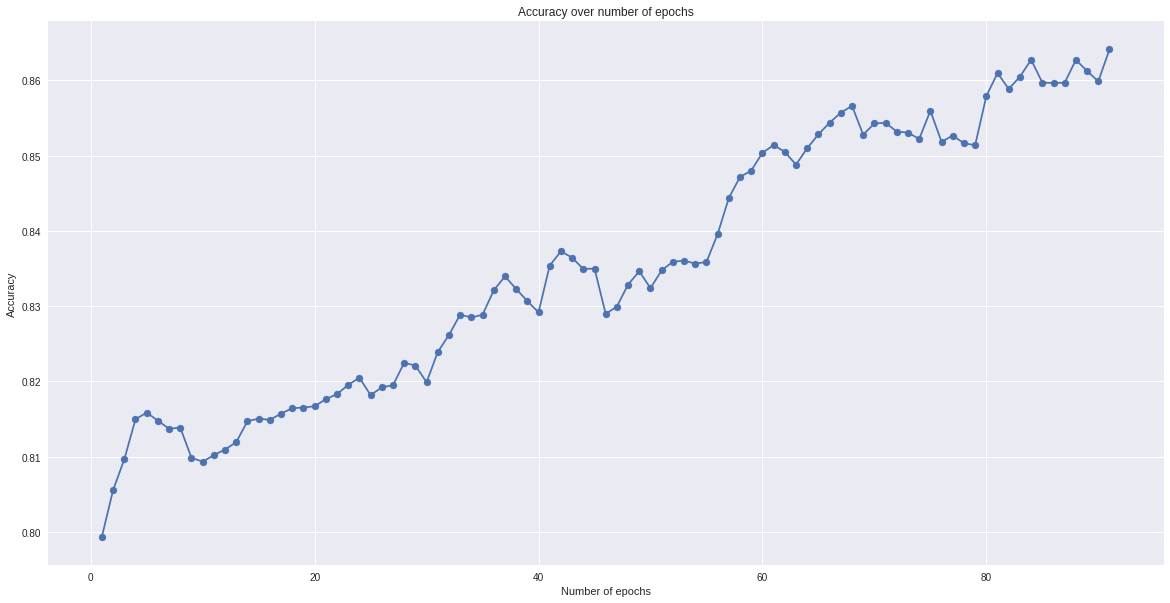

In [0]:
#Data visualization
#Cost and accuracy and epoch graph
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(np.arange(1,92),costacc[:91,1])
ax.scatter(np.arange(1,92),costacc[:91,1])
ax.set(title='Accuracy over number of epochs',ylabel='Accuracy',xlabel='Number of epochs')
plt.show()

In [0]:
attNames = ['Hairband','Hat','HeadPhone','Kerchief','Muffler','NoAccessory','Sunglass','Backpack','MessengerBag','NoCarry','OtherCarry','PlasticBag',
            'SuitCase','Boots','LeatherShoe','Sandal','Shoes','Sneakers','Stocking','HairBald','HairLong','HairShort','lowerCapri','lowerCasual','lowerFormal',
            'lowerHotPants','lowerJeans','lowerLongSkirt','lowerShortSkirt','lowerShirts','lowerTrousers','Female','Age>60','Age<15','Age<30','Age<45','Age<60',
            'Male','upperCasual','upperFormal','upperJacket','upperLongSleeve','upperOther','upperPlaid','upperShortSleeve','upperTshirt','upperVneck']

In [0]:
for i in range(47):
  print(f'{attNames[i]} accuracy = {accperAtt[i]}')

In [0]:
# Import `pyplot`
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(121)

ax.bar(np.arange(1,48),accperAtt[:])
ax.set(title='Recognition accuracy',ylabel='Accuracy',xlabel='47 Pedestrian Attributes')
ax.xaxis.set(ticks=np.arange(49),ticklabels=attNamesTicks)
ax.tick_params(axis='x',direction='inout',labelrotation=90,labelsize=14)
plt.show()

In [0]:
#Code for comparing and analysing detected and actual attributes
#Best 13 matches 183, 718, 1769, 2270 best matche 13/13 All belonging to the same pedestrian
#12 matches 108,265,343,381,664,682,704,784,1020,1033,1104,1123,1126,1133,1155,1163,1184,1189,1241,1279,1399,1605,1620,1639,
#12 matches 1765,1789,1984,2008,2125,2136,2215,2223,2265,2289,2340,2437,2550,2556,2655,2682,2863,3001,3050,3132,3216,3227 
#Least 0 match 2537
#Just 1 match 375, 376, 746, 2573, 2582, 2951, 3029
#Just 2 match 69,230,373,591,600,803,1208,1410,1841,1869
fig = plt.figure()
ax = fig.add_subplot(131)
k = 1869
ax.imshow(X_test[k].astype(np.uint8))
for i,j in enumerate(predictedValuesTrue[k]):
  if j == 1:
    print(f'{attrs[i]} = True')

print('\n\nActual values\n')
for i,j in enumerate(Y_test[k]):
  if j == 1:
    print(f'{attrs[i]} = True')

In [0]:
#Code for finding number of positive attribute matches per image
matchcount = []
for i in range(len(predictedValuesTrue)):
  count = 0
  for j in range(len(predictedValuesTrue[i])):
    if predictedValuesTrue[i][j] == 1:
      if predictedValuesTrue[i][j] == Y_test[i][j]:
        count += 1
  matchcount.append(count)

In [0]:
#Code for matching number of detections with images
bestpositives = []
for i in range(len(matchcount)):
  if matchcount[i] == 2:
    bestpositives.append(i)

(1, 30, 15, 32)
(1, 30, 15, 64)


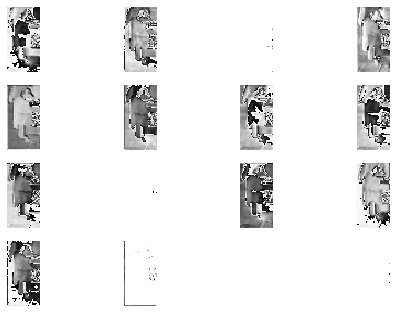

In [0]:
x = tf.reshape(X_test[100],[-1,120,60,3])
    
conv1 = tf.nn.conv2d(x,Weights['W_Conv1'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv1']
conv1 = tf.nn.relu(conv1)
conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
fig,axes = plt.subplots(4,4)

#print(sess.run(conv3[0,:,:,64])) #image number,height,width,filternumber
for i, ax in enumerate(axes.flat):
  z = sess.run(conv1[0,:,:,i])
  ax.set_xticks([]) 
  ax.set_yticks([])
  ax.imshow(z.astype(np.uint8))
  
conv2 = tf.nn.conv2d(conv1,Weights['W_Conv2'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv2']
conv2 = tf.nn.relu(conv2)
conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print(conv2.shape)


conv3 = tf.nn.conv2d(conv2,Weights['W_Conv3'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv3']
conv3 = tf.nn.relu(conv3)
conv3 = tf.nn.max_pool(conv3,ksize=[1,4,2,1],strides=[1,1,1,1],padding='SAME')
print(conv3.shape)


(1, 30, 15, 32)
(1, 30, 15, 64)


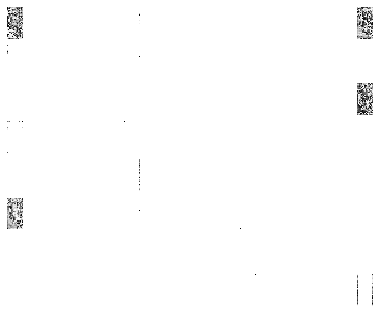

In [0]:
x = tf.reshape(X_test[100],[-1,120,60,3])
    
conv1 = tf.nn.conv2d(x,Weights['W_Conv1'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv1']
conv1 = tf.nn.relu(conv1)
conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

conv2 = tf.nn.conv2d(conv1,Weights['W_Conv2'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv2']
conv2 = tf.nn.relu(conv2)
conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print(conv2.shape)

fig,axes = plt.subplots(8,4)

#print(sess.run(conv[0,:,:,64])) #image number,height,width,filternumber
for i, ax in enumerate(axes.flat):
  z = sess.run(conv2[0,:,:,i])
  ax.set_xticks([]) 
  ax.set_yticks([])
  ax.imshow(z.astype(np.uint8))

conv3 = tf.nn.conv2d(conv2,Weights['W_Conv3'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv3']
conv3 = tf.nn.relu(conv3)
conv3 = tf.nn.max_pool(conv3,ksize=[1,4,2,1],strides=[1,1,1,1],padding='SAME')
print(conv3.shape)


(1, 30, 15, 32)
(1, 30, 15, 64)


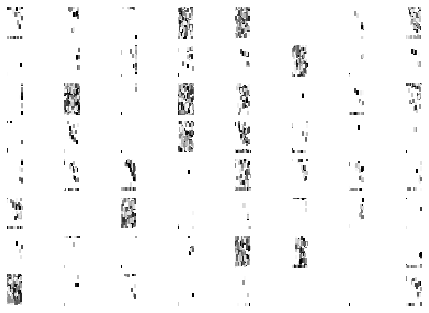

In [0]:
x = tf.reshape(X_test[100],[-1,120,60,3])
    
conv1 = tf.nn.conv2d(x,Weights['W_Conv1'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv1']
conv1 = tf.nn.relu(conv1)
conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

conv2 = tf.nn.conv2d(conv1,Weights['W_Conv2'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv2']
conv2 = tf.nn.relu(conv2)
conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print(conv2.shape)


conv3 = tf.nn.conv2d(conv2,Weights['W_Conv3'],strides=[1,1,1,1],padding='SAME') + Biases['B_Conv3']
conv3 = tf.nn.relu(conv3)
conv3 = tf.nn.max_pool(conv3,ksize=[1,4,2,1],strides=[1,1,1,1],padding='SAME')
print(conv3.shape)
fig,axes = plt.subplots(8,8)

#print(sess.run(conv3[0,:,:,64])) #image number,height,width,filternumber
for i, ax in enumerate(axes.flat):
  z = sess.run(conv3[0,:,:,i])
  ax.set_xticks([]) 
  ax.set_yticks([])
  ax.imshow(z.astype(np.uint8))

In [0]:
bestpositives

[69,
 230,
 373,
 591,
 600,
 803,
 1208,
 1410,
 1841,
 1869,
 2021,
 2087,
 2091,
 2173,
 2357,
 2436,
 2594,
 2698,
 2776,
 3178,
 3308,
 3345,
 3404,
 3499]

In [0]:
import matplotlib.image as mpimage
fig = plt.figure()
ax = fig.add_subplot(111)
m = mpimage.imread('/content/gdrive/My Drive/arif.bmp')
ax.imshow(m.astype(np.uint8))